# Исследование аномалий в дампе трафика

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pyflux as pf
from pandas.plotting import autocorrelation_plot
import time

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Данный дамп был получен в ходе эмуляции сети IoT в течении 24 часов. Топология сети:

- CoAP-сервер
- 2 CoAP-датчика

In [2]:
df_train=pd.read_csv("normal_traffic_2.csv")
df_train.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000e+00,192.168.1.118,224.0.0.251,MDNS,124,Standard query response 0x0000 PTR 673DD953-CF...
1,2,1.920000e-07,fe80::1859:13ec:539b:c695,ff02::fb,MDNS,144,Standard query response 0x0000 PTR 673DD953-CF...
2,3,1.696371e-01,192.168.1.129,104.75.50.218,TCP,66,42148 > 443 [ACK] Seq=1 Ack=1 Win=501 Len=0 ...
3,4,1.860416e-01,104.75.50.218,192.168.1.129,TCP,66,[TCP ACKed unseen segment] 443 > 42148 [ACK]...
4,5,7.508680e-01,104.75.59.53,192.168.1.129,TLSv1.2,97,Encrypted Alert


Протоколы, встречающиеся в тренировочном датасете

In [3]:
df_train["Protocol"].unique()

array(['MDNS', 'TCP', 'TLSv1.2', 'ARP', 'CoAP', 'DNS', 'TLSv1.3', 'NTP',
       'SSDP', 'ICMPv6', 'HTTP', 'NBNS', 'LLMNR', 'QUIC', 'BROWSER',
       'IGMPv3', 'ICMP', 'DHCP', 'DHCPv6', 'SSLv2'], dtype=object)

Из всего датасета выделяем оставляем только столбец "Time", так как он несет в себе всю основную информацию о загруженности сети, а значит и наличии DOS-атаки в рассматриваемом дампе

In [4]:
df_test=pd.read_csv("dos_traffic.csv")
df_test.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,192.168.1.18,239.255.255.250,SSDP,216,M-SEARCH * HTTP/1.1
1,2,0.286633,192.168.1.71,192.168.1.129,CoAP,65,"CON, MID:26429, PUT, TKN:2c 65, /temperature"
2,3,0.287794,192.168.1.129,192.168.1.71,CoAP,53,"ACK, MID:26429, 2.04 Changed, TKN:2c 65, /temp..."
3,4,1.000404,192.168.1.18,239.255.255.250,SSDP,216,M-SEARCH * HTTP/1.1
4,5,2.000600,192.168.1.18,239.255.255.250,SSDP,216,M-SEARCH * HTTP/1.1


Протоколы, встречающиеся в тестовом даттасете

In [5]:
df_test["Protocol"].unique()

array(['SSDP', 'CoAP', 'ARP', 'ICMPv6', 'MDNS', 'IGMPv3', 'DNS', 'TCP',
       'HTTP', 'NTP', 'BROWSER'], dtype=object)

In [6]:
def extract_time_col(df):
    df=df.sort_values(["Time"],axis=0)
    df=df.loc[:,["Time"]]
    df.reset_index(drop=True)
    print(df.head())
    return df

In [7]:
df_train=extract_time_col(df_train)

           Time
0  0.000000e+00
1  1.920000e-07
2  1.696371e-01
3  1.860416e-01
4  7.508680e-01


In [8]:
df_test=extract_time_col(df_test)

       Time
0  0.000000
1  0.286633
2  0.287794
3  1.000404
4  2.000600


Функция '''calc_num_pack_per_second''' преобразует исходный в датасет в новый, где каждая запись содержит количество пакетов переданных на CoAP-server за 2 секунды (значение по умолчанию)

In [9]:
def calc_num_pack_per_second(x,delay=2):
    source_arr=x.to_numpy()
    start=0
    counter=0
    result=[]
    j=0;
    i=0;
    while i<source_arr.size:
        while i+j<source_arr.size and source_arr[i+j]>=start and source_arr[i+j]<start+delay:
            counter=counter+1
            j=j+1
        i=i+j
        start=start+delay
        j=0
        result.append(counter)
        counter=0
    return pd.DataFrame(data=pd.Series(result),columns=["num_of_packets"])
        

In [10]:
df_train=calc_num_pack_per_second(df_train,delay=2)
df_train.describe()

,num_of_packets
count,42167.000000
mean,2.264330
std,9.466863
min,0.000000
25%,0.000000
50%,2.000000
75%,2.000000
max,875.000000


Согласно статистике выше, средняя скорость(пакет/сек) передачи пакетов в дампе составляет 1 пакет/сек. К сожалению, дамп содержит в себе аномалии (максимальный выброс 875 пакет/сек), что плохо для обучения модели.

"Выбросы" хорошо видно на графике ниже

In [11]:
def display_dataset(df):
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
    return sns.lineplot(data=df)

<AxesSubplot:>

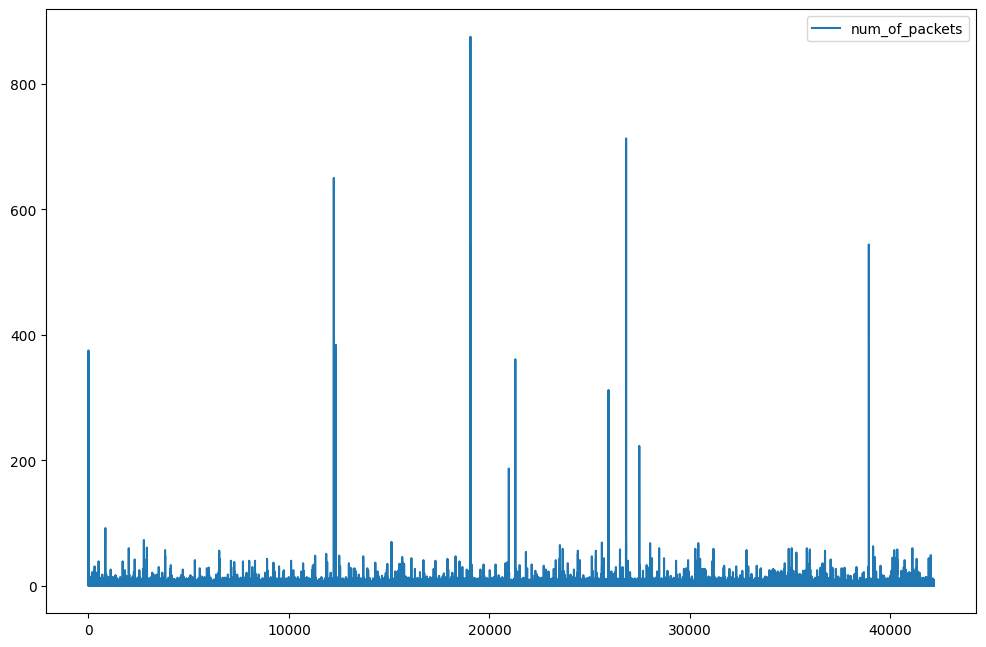

In [12]:
display_dataset(df_train)

Удалим данные аномалии из датасета. Результат данной операции отображен на графике ниже.

[(0.0, 800.0)]

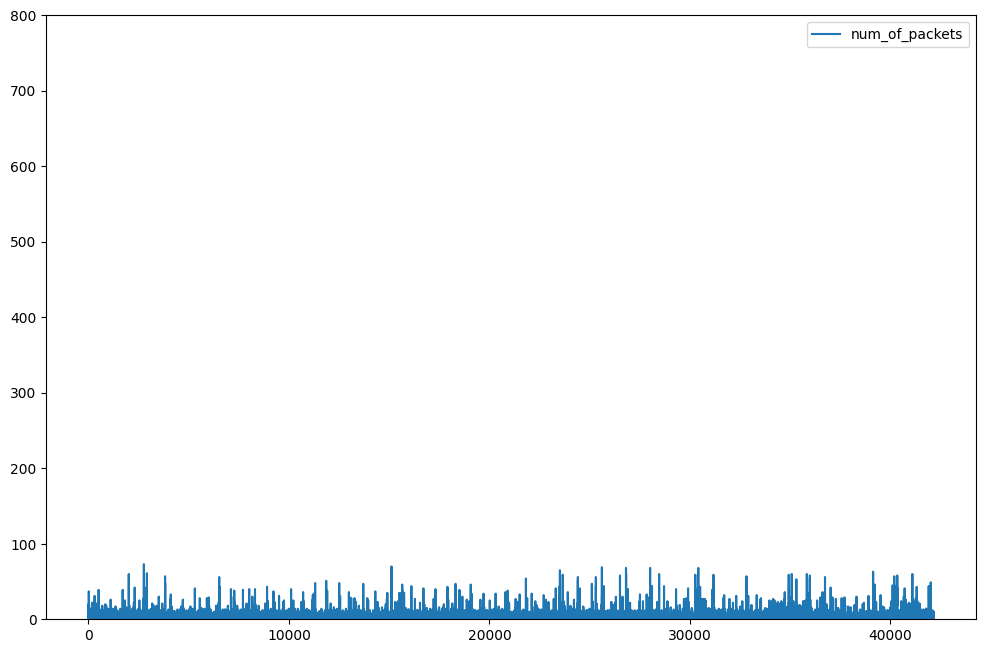

In [13]:
df_train=df_train.query("num_of_packets < 80")
#df=df.iloc[0:1000,:]
g=display_dataset(df_train)
g.set(ylim=(0, 800))

In [14]:
df_test=calc_num_pack_per_second(df_test,delay=2)
df_test.describe()

,num_of_packets
count,604.000000
mean,161.498344
std,110.729729
min,0.000000
25%,4.000000
50%,192.000000
75%,228.000000
max,454.000000


<AxesSubplot:>

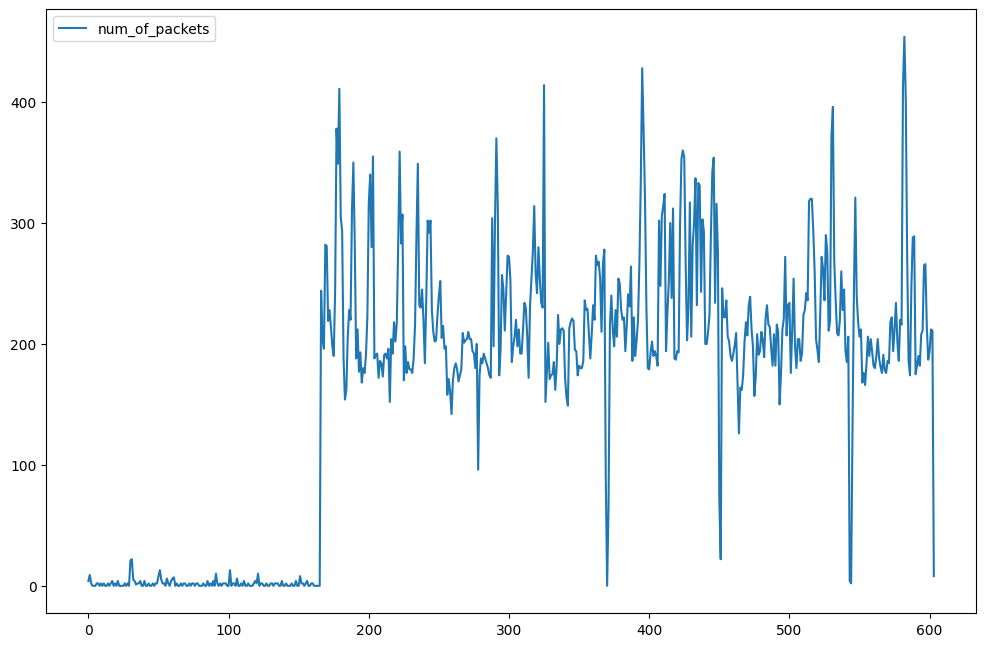

In [15]:
display_dataset(df_test)

Данный график отображает часть датасета, которая содержит в себе аномалии (DOS-атаку)

Для того, чтобы понять как сильно значения в датасете зависят друг от друга, нарисуем график корреляции значений между собой.

[(0.0, 100.0)]

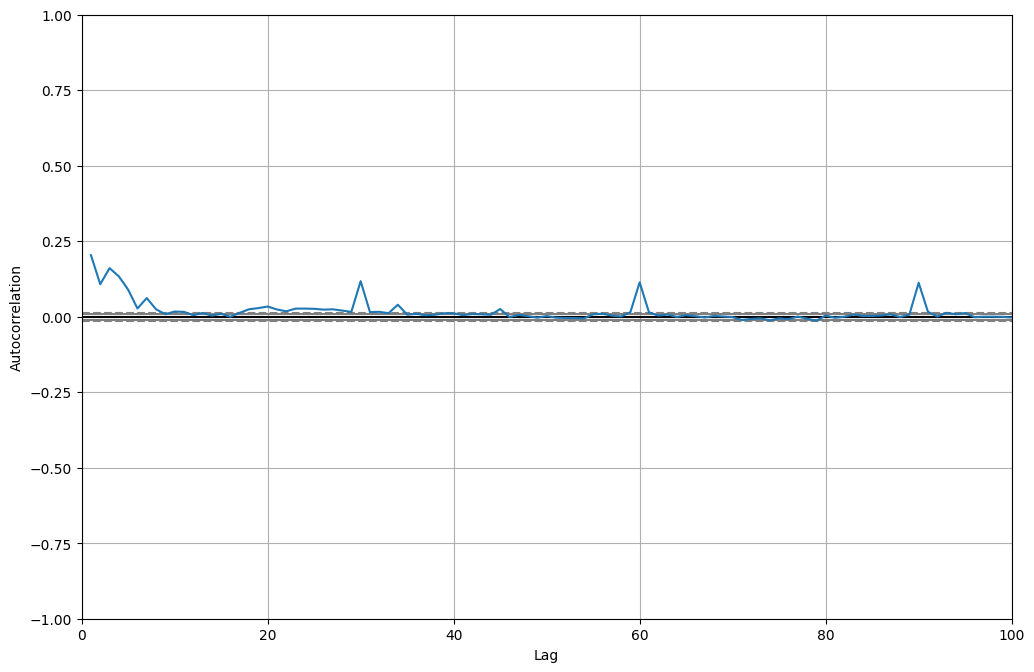

In [16]:
pl=autocorrelation_plot(df_train)
pl.set(xlim=(0, 100))

Как можно видеть из графика наиболее сильная зависимость свойственная соседним значениям в датасете. Также можно заметить, что каждые 30 значений есть небольшой всплеск. Это может быть объяснено тем, что датчики передавали сообщения по расписанию (каждые 10-15 секунд)

In [17]:
df=pd.concat([df_train, df_test], ignore_index=True)
df.describe()

,num_of_packets
count,42754.000000
mean,4.369065
std,23.306020
min,0.000000
25%,0.000000
50%,2.000000
75%,2.000000
max,454.000000


<AxesSubplot:>

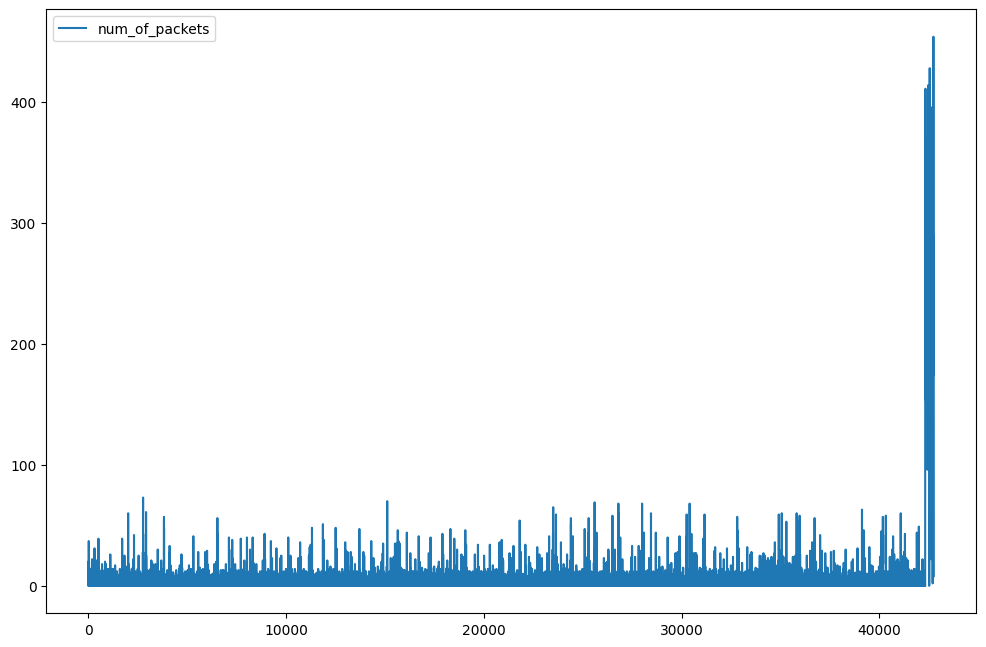

In [18]:
display_dataset(df)

После объединения тернировочного и тестового датасетов можно отчетливо различить аномалию в правой части графика на фоне "нормального" трафика

In [51]:
df["is_dos"]=False
df["is_dos"].iloc[len(df)-438:]=True

## Модель ARIMA

In [20]:
model_a=pf.ARIMA(data=df_train,ar=11,ma=11,integ=0,target='num_of_packets')

In [21]:
global_start_time = time.time()
x=model_a.fit("M-H")
print('Training duration:{}'.format(time.time() - global_start_time))

Acceptance rate of Metropolis-Hastings is 0.0
Acceptance rate of Metropolis-Hastings is 0.01085
Acceptance rate of Metropolis-Hastings is 0.39735

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.338275
Training duration:514.5366728305817


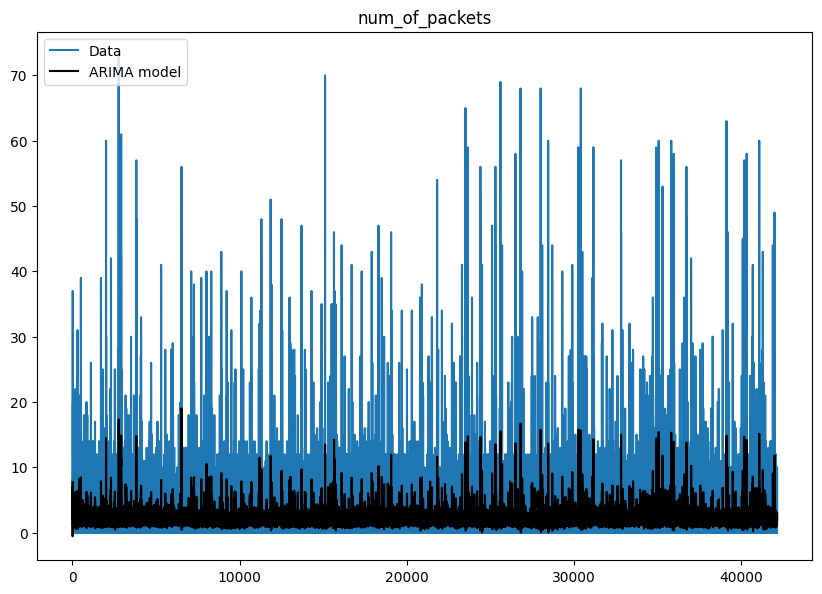

In [22]:
model_a.plot_fit()

Синим цветом на графике отмечены реальные значения, а черным значения, которые были получены моделью. Межде ними есть существенное различие, значения, результаты рассчитанные моделью имеют меньшие абсолютные значения, чем оригинальные. Это обусловлено тем, что большая часть записей датасета находится в промежутке между 0 и 10, и модель ориентируется на них, то есть она успешно выполняет главную задачу - выучить основной "тренд" в датасете

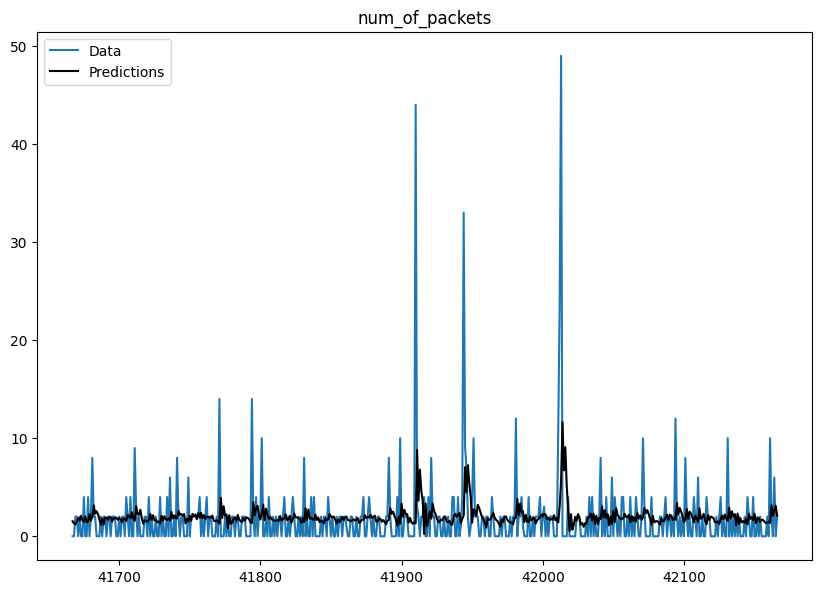

In [23]:
model_a.plot_predict_is(h=500)

Оценить эффективность работы модели ARIMA можно и без тестового датасета. Для этого используется метод plot_predict_is, которые представляет последние 1000 записей датасета (h=604), как неизвестные для модели, и пытается предсказать их. График выше отображает результаты данного процесса

Включим модель в режиме предсказания и отобразим следующие 1000 значений

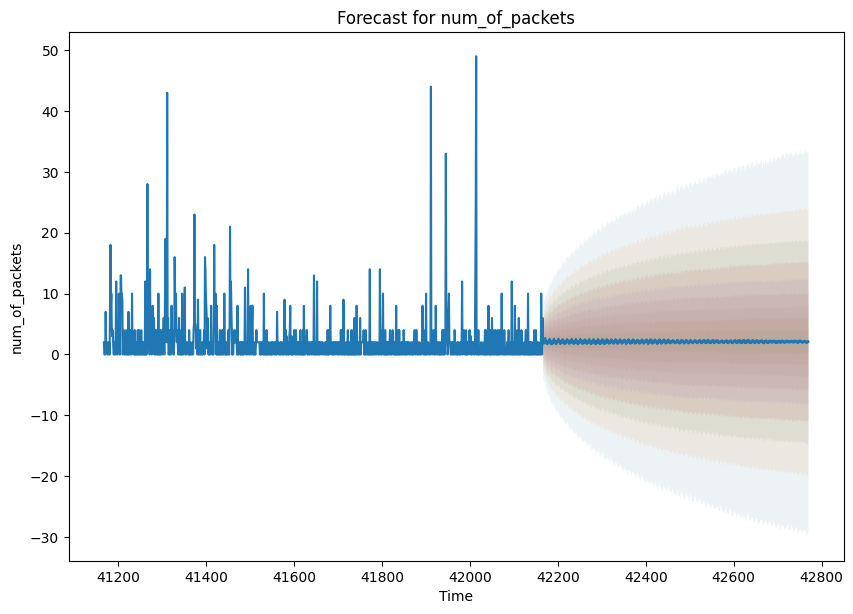

In [24]:
model_a.plot_predict(h=604, past_values=1000)

In [25]:
df

,num_of_packets,is_dos
0,16,False
1,16,False
2,15,False
3,8,False
4,20,False
...,...,...
42749,187,True
42750,194,True
42751,212,True
42752,211,True


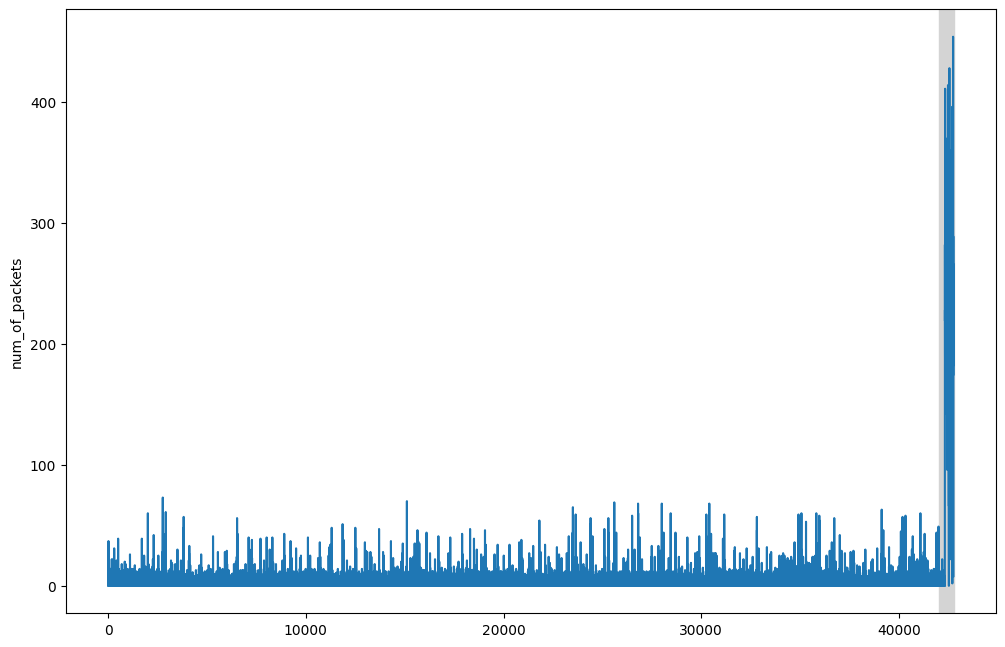

In [26]:
g=display_dataset(df.num_of_packets)
g.axvspan(xmin=42000,xmax=len(df), color='#d4d4d4')

Как видно из двух графиков выше, модель ARIMA предсказывает будущие значения примерно от 0 до 5, а в тестовом датасете данные достигают значения нескольких сотен. То есть можно сделать вывод, что данная модель успешно детектирует аномалии в трафике, вызванные DOS-атакой

In [27]:
predict_a=model_a.predict(h=604)
predict_a=predict_a.reset_index(drop=True)["num_of_packets"]
predicted_a=predict_a.to_numpy()

In [28]:
y_test=df["num_of_packets"].iloc[len(df)-604:]
y_test.reset_index(drop=True)
y_test=y_test.to_numpy()

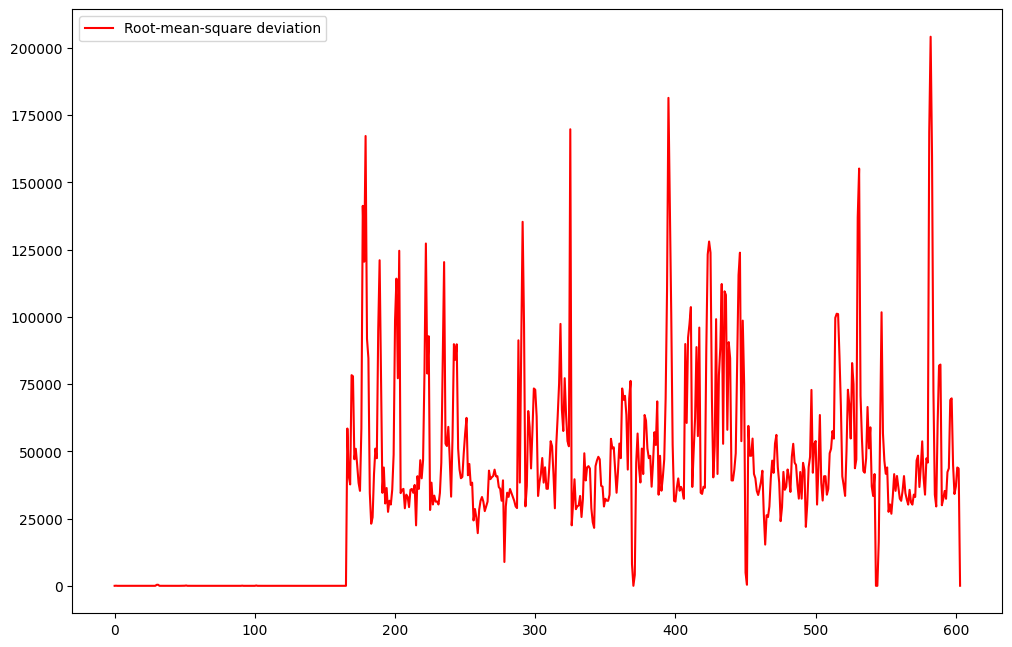

In [29]:
diff=((y_test - predict_a) ** 2).to_numpy()
plt.plot(diff, 'r', label='Root-mean-square deviation')
plt.legend()
plt.show()

Определим, что в случае, если среднее квадратичное отклонение реального трафика от предсказанных значений превышает значение в 5000, то данная запись в датасете относится к DOS-атаке

In [30]:
test_labels=df["is_dos"].iloc[len(df)-604:]
test_labels=test_labels.reset_index(drop=True)
print(type(diff))
evaluation_df_a=pd.DataFrame(data=diff,columns=["diff"])
evaluation_df_a["test_labels"]=pd.Series(test_labels)
evaluation_df_a["predicted_labels"]=evaluation_df_a["diff"]>5000
evaluation_df_a

<class 'numpy.ndarray'>


,diff,test_labels,predicted_labels
0,4.909866,False,False
1,45.522856,False,False
2,0.059157,False,False
3,3.108872,False,False
4,6.960109,False,False
...,...,...,...
599,34134.220943,True,True
600,36900.630538,True,True
601,43992.163947,True,True
602,43601.044852,True,True


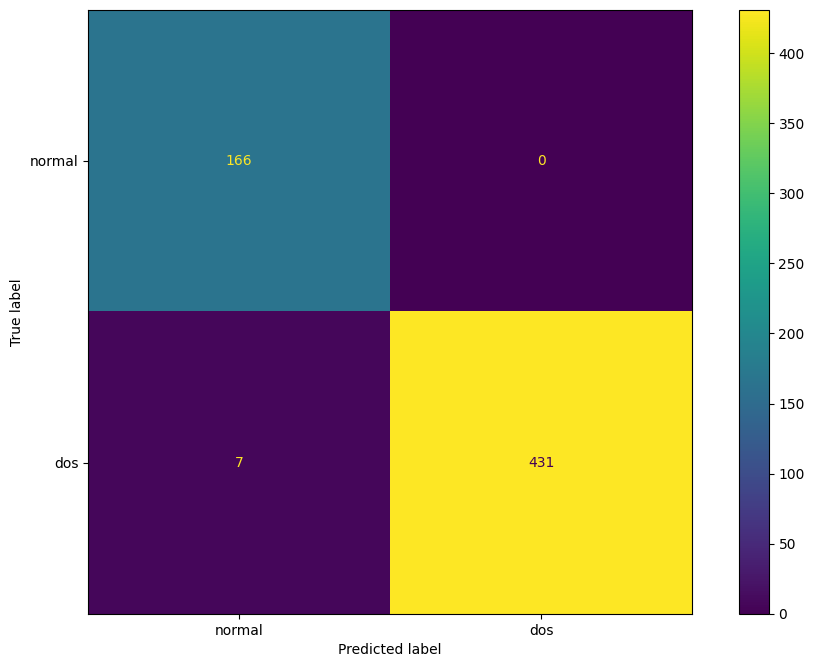

In [52]:
cm=confusion_matrix(evaluation_df_a["test_labels"], evaluation_df_a["predicted_labels"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["normal","dos"])
disp.plot()

## Рекурретная нейронная сеть 

In [32]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout

In [33]:
epochs = 10
batch_size = 50

In [34]:
# Each training data point will be length 100-1,
# since the last value in each sequence is the label
sequence_length = 100

In [35]:
def generate_model():

    model = Sequential()

    # First LSTM layer defining the input sequence length
    model.add(LSTM(input_shape=(sequence_length-1, 1),
                   units=32,
                   return_sequences=True))
    model.add(Dropout(0.2))

    # Second LSTM layer with 128 units
    model.add(LSTM(units=128,
                   return_sequences=True))
    model.add(Dropout(0.2))

    # Third LSTM layer with 100 units
    model.add(LSTM(units=100,
                   return_sequences=False))
    model.add(Dropout(0.2))

    # Densely-connected output layer with the linear activation function
    model.add(Dense(units=1))
    model.add(Activation('linear'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    
    return model

In [36]:
def normalize(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

In [37]:
def prepare_data(data, train_start, train_end, test_start, test_end, do_normalize=False):
    print("Length of Data", len(data))

    # training data
    print("Creating training data...")
    #test_labels=data["is_dos"].iloc[test_start:test_end]
    #data_array=data['num_of_packets'].to_numpy()
    #print(data_array)

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result, dtype=float)
    if do_normalize:
        result, result_mean = normalize(result)

    print("Training data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]

    # test data
    print("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result, dtype=float)
    if do_normalize:
        result, result_mean = normalize(result)

    print("Test data shape  : {}".format(result.shape))

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test

In [38]:
def run(model=None, data=None):
    global_start_time = time.time()

    print('Loading data... ')
    test_labels=data["is_dos"].iloc[len(data)-604:]
    data = data['num_of_packets'].to_numpy()

    # train on first 700 samples and test on next 300 samples (test set has anomaly)
    X_train, y_train, X_test, y_test = prepare_data(data, 0, 42000, len(data)-604-sequence_length, len(data))

    if model is None:
        model = generate_model()

    try:
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size, epochs=epochs, validation_split=0.05)
        print("Predicting...")
        predicted = model.predict(X_test)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print('Training duration:{}'.format(time.time() - global_start_time))
        return model, y_test, 0

    try:
        plt.figure(figsize=(20,8))
        #plt.plot(y_test[:len(y_test)], 'b', label='Observed')
        plt.plot(y_test, 'b', label='Observed')

        #plt.plot(predicted[:len(y_test)], 'g', label='Predicted')
        plt.plot(predicted, 'g', label='Predicted')

        plt.plot(((y_test - predicted) ** 2), 'r', label='Root-mean-square deviation')
        plt.legend()
        plt.show()
    except Exception as e:
        print("plotting exception")
        print(str(e))
    print('Training duration:{}'.format(time.time() - global_start_time))

    return model, y_test, predicted, test_labels

Loading data... 
Length of Data 42754
Creating training data...
Training data shape  :  (41900, 100)
Creating test data...
Test data shape  : (604, 100)
Shape X_train (41900, 99)
Shape X_test (604, 99)
Training...
Epoch 1/10
797/797 [==============================] - 245s 302ms/step - loss: 16.0574 - val_loss: 17.4632
Epoch 2/10
797/797 [==============================] - 227s 285ms/step - loss: 15.0045 - val_loss: 17.3740
Epoch 3/10
797/797 [==============================] - 227s 285ms/step - loss: 15.5704 - val_loss: 17.1204
Epoch 4/10
797/797 [==============================] - 226s 283ms/step - loss: 14.8539 - val_loss: 16.6746
Epoch 5/10
797/797 [==============================] - 226s 284ms/step - loss: 14.6505 - val_loss: 16.3961
Epoch 6/10
797/797 [==============================] - 228s 287ms/step - loss: 14.3172 - val_loss: 16.7434
Epoch 7/10
797/797 [==============================] - 240s 301ms/step - loss: 13.9131 - val_loss: 16.2530
Epoch 8/10
797/797 [========================

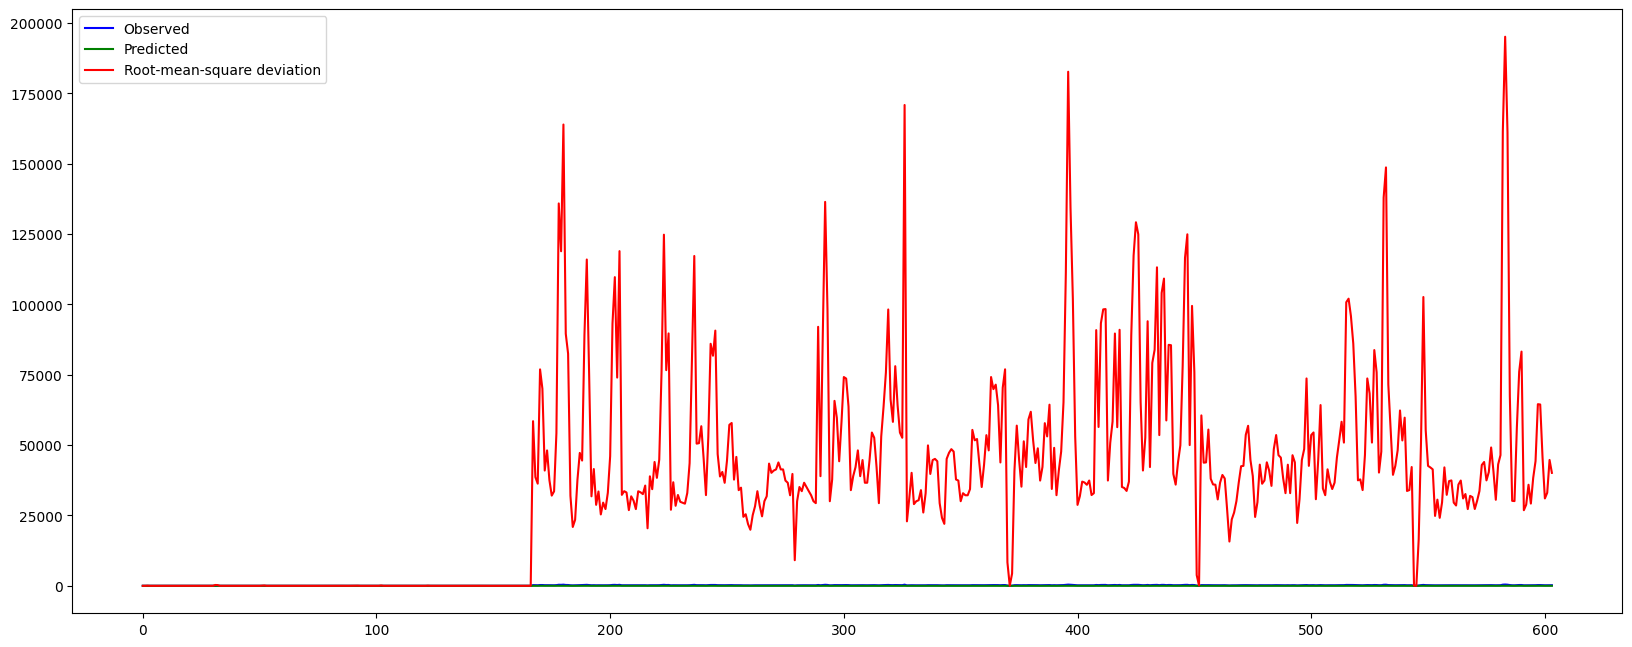

Training duration:2324.430502653122


In [39]:
model, y_test, predicted, test_labels = run(data=df)

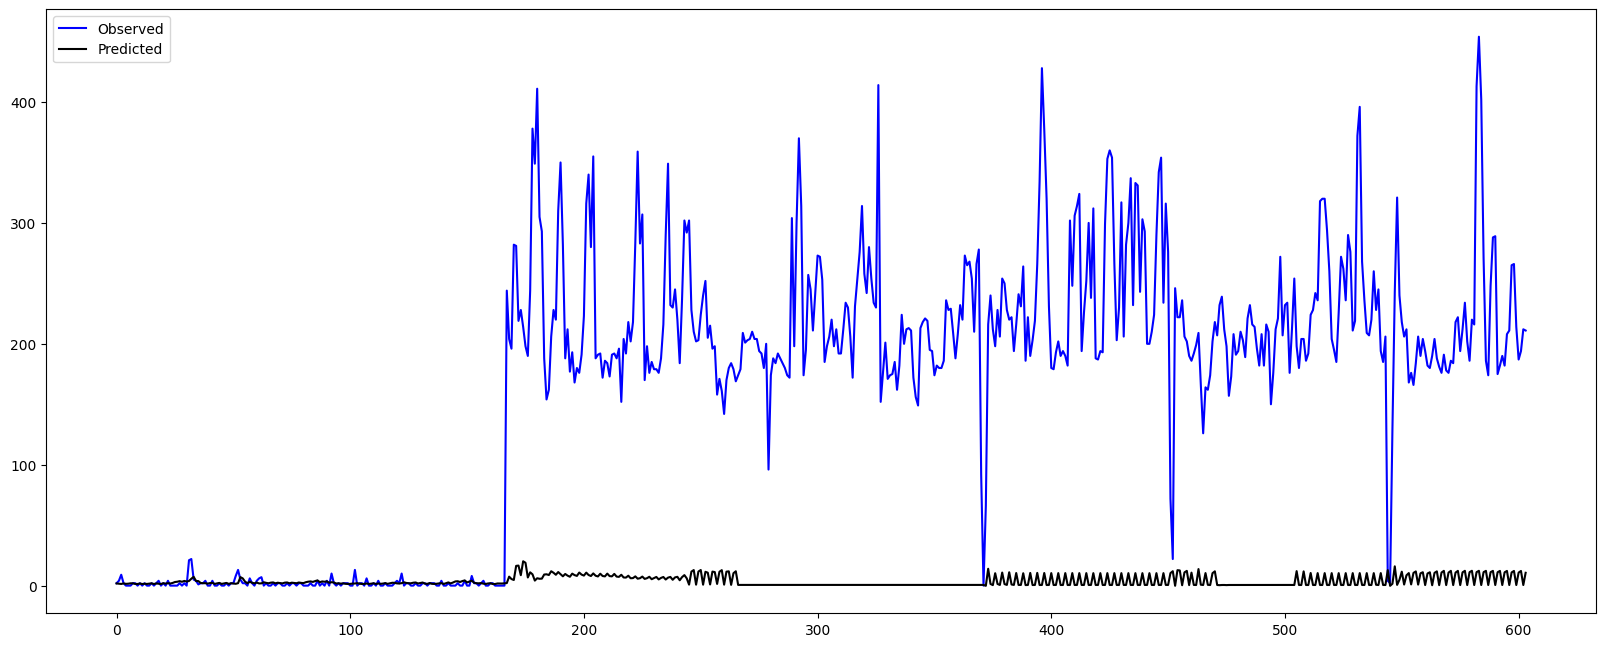

In [40]:
plt.figure(figsize=(20,8))
#plt.plot(y_test[:len(y_test)], 'b', label='Observed')
plt.plot(y_test, 'b', label='Observed')
plt.plot(predicted, 'black', label='Predicted')
plt.legend()
plt.show()

На графике выше синим цветом отображены реальные значения датасета, а черным те, что были предсказаны нейронной сетью. На основе данного изображения можно сказать, что модель успешно выучила основные особенности датасета

Если применить функцию среднего квадратичного отклонения для сравнения реального и предсказанного значения, то получим график, изображенный ниже.

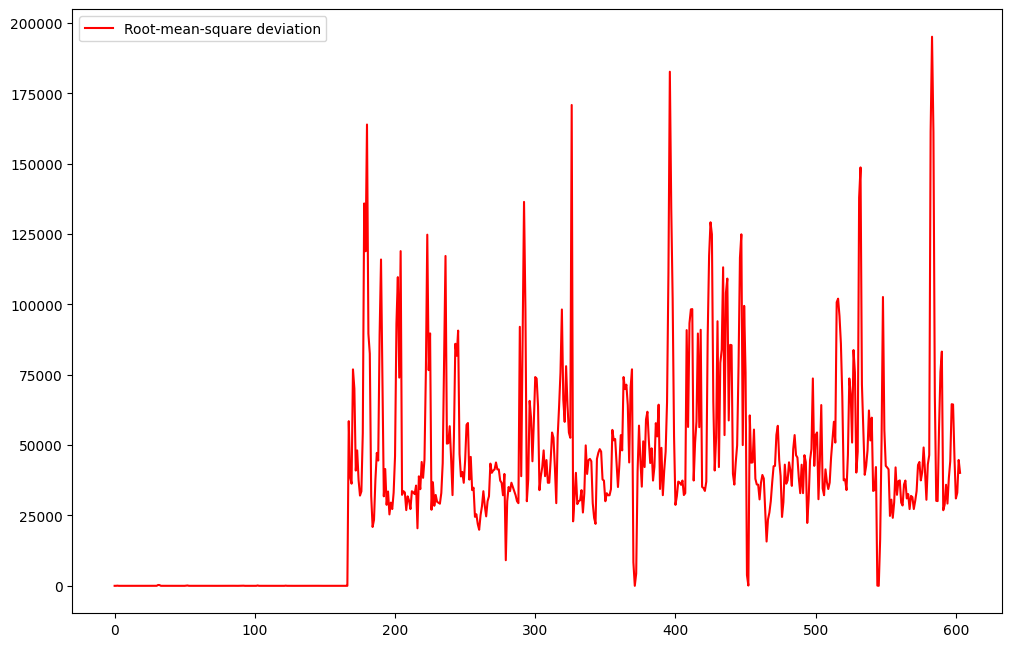

In [41]:
diff=((y_test - predicted) ** 2)
plt.plot(diff, 'r', label='Root-mean-square deviation')
plt.legend()
plt.show()

Выбросы на графике показывают места, где есть существенная разница между предсказанным значением и реальным. Использование данной функции позволяет упростить детектирование аномалий в трафике, представленных в виде DOS-атаки, так как масштаб данного графика в разы больше, чем у предыдущего (выбросы более отчетливые).

Определим, что в случае, если среднее квадратичное отклонение реального трафика от предсказанных значений превышает значение в 5000, то данная запись в датасете относится к DOS-атаке

In [42]:
test_labels=test_labels.reset_index(drop=True)
evaluation_df=pd.DataFrame(data=diff,columns=["diff"])
evaluation_df["test_labels"]=pd.Series(test_labels)
evaluation_df["predicted_labels"]=evaluation_df["diff"]>5000
evaluation_df.iloc[len(evaluation_df)-440:]

,diff,test_labels,predicted_labels
164,3.066657,False,False
165,3.064240,False,False
166,3.803169,True,False
167,58518.412548,True,True
168,38639.439719,True,True
...,...,...,...
599,45592.126014,True,True
600,31052.191448,True,True
601,33077.036464,True,True
602,44742.771779,True,True


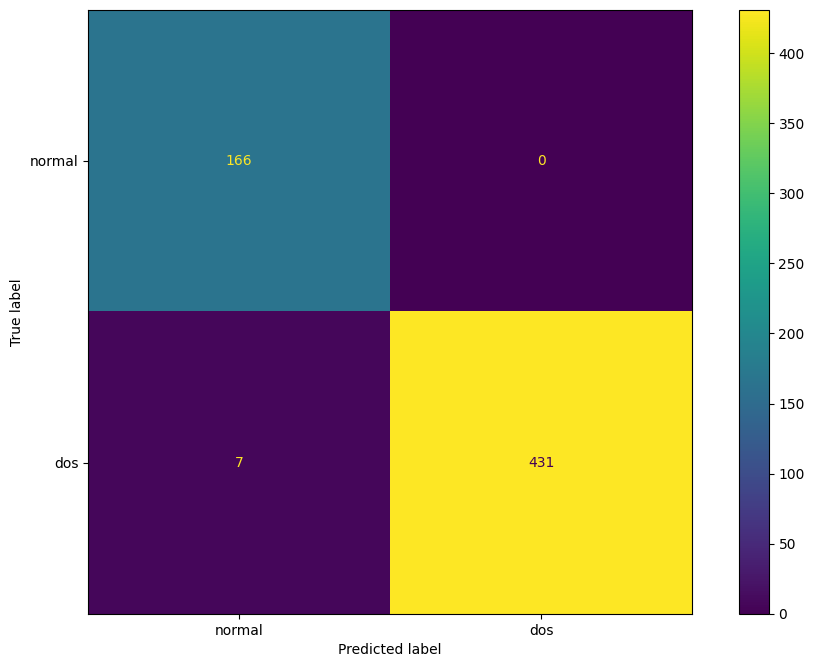

In [44]:
cm=confusion_matrix(evaluation_df["test_labels"], evaluation_df["predicted_labels"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["normal","dos"])
disp.plot()